In [1]:
import sys
from pathlib import Path

import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd

sys.path.append('../lib')
from hier_group import unpack_hier_names
from local_paths import analysis_dir, database_dir, mplstyle_path
from summary_utils import verified_update, annotate_unit_df, select_units, summarize_results_per_region, region_palette
from stats_utils import get_bootstrap_spread, fdr_correction
from plot_utils import annotate_per_region_axes, axis_off_save_labels

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
# analysis_name = 'self_consistency'
analysis_name = 'self_consistency_match_control'
results_dir = analysis_dir + analysis_name

# analysis-specific conditions
pal = palettable.cartocolors.qualitative.Bold_10.mpl_colors
if 'match_control' in analysis_name:
    conds = ('Return', 'Match')
    cond_palette = dict(zip(conds, (pal[0], pal[2])))
else:
    conds = ('Current', 'Previous')
    cond_palette = dict(zip(conds, (pal[0], pal[1])))

# unit selection
unit_sel_path = database_dir + 'unit_sel/visually_selective.csv.gz'

# statistics
spread_type = 'ci_of_mean'
if 'match_control' in analysis_name:
    test_dset = 'permutation_test/current_v_current_match_previous'
else:
    test_dset = 'permutation_test/current_v_previous'

# Load data

In [4]:
unit_df = {'Session': [], 'Unit': []}
results = {k: [] for k in ('cond0', 'cond1', 'pvals')}
coords = {}

results_dir = Path(results_dir).expanduser()
for fp in results_dir.glob('*.h5'):
    with h5.File(fp, 'r') as f:
        try:
            assert f[f'progress_report/{analysis_name}/all_done'][()]
            dset = f[f'{analysis_name}/{test_dset}']
        except (KeyError, AssertionError):
            continue

        verified_update(coords, dict(time=dset['time'][()]))

        unit_names = dset['unit'][()].astype(str)
        unit_names = unpack_hier_names(unit_names)
        usel = unit_names[:,0] == 'Unit'
        unit_names = unit_names[usel,1]

        results['cond0'].append(dset['cond0'][()][:,usel])
        results['cond1'].append(dset['cond1'][()][:,usel])

        alts = dset['alternative'][()].astype(str)
        i0 = list(alts).index('greater')
        pvals = dset['p-value'][i0,:,usel]
        results['pvals'].append(pvals)

    unit_df['Session'].append(np.full(unit_names.size, fp.stem))
    unit_df['Unit'].append(unit_names)

print('coordinates:')
for k, v in coords.items():
    print('\t', k, v.shape, v.dtype)
print('results:')
for d in (results, unit_df):
    for k, v in d.items():
        d[k] = v = np.concatenate(v, axis=-1)
        print('', f'{k:<15s}', v.shape, v.dtype, sep='\t')
print(np.unique(unit_df['Session']).size, 'sessions')
unit_df = annotate_unit_df(pd.DataFrame(unit_df))

coordinates:
	 time (75,) int64
results:
	cond0          	(75, 63966)	float32
	cond1          	(75, 63966)	float32
	pvals          	(75, 63966)	float64
	Session        	(63966,)	<U10
	Unit           	(63966,)	object
647 sessions


# Select units

In [5]:
result_vals = np.array([
    results['cond0'],
    results['cond1']])
pvals = results['pvals']
del results

In [6]:
unit_df, unit_sel, regions = select_units(
    unit_df,
    selection_path=unit_sel_path,
    select_valid_values=result_vals)

result_vals = result_vals[...,unit_sel]
pvals = pvals[...,unit_sel]
n = '5i' if analysis_name == 'self_consistency_match_control' else '5h1'
unit_df.reset_index()[['Session','Unit']].to_csv(F'unit_sel/fig{n}.csv.gz', index=False)

> Selected units: n = 26427 of 63966 (41.3% of data, 98.0% of selection) based on visually_selective.csv.gz
> Selected units: n = 23214 of 26427 (87.8%) with valid values
> Excluded 2 rare subjects per region:
	                Units  Norm. units
	Region Subject                    
	AIT    Ot           3     0.005576
	CIT    Re          28     0.031891
  Selected units: n = 23183 of 23214 (99.9%)


# Self-consistency

In [7]:
summary = summarize_results_per_region(
    unit_df=unit_df,
    result_vals=result_vals,
    conds=conds,
    spread_type=spread_type)

center/spread estimate: ci_of_mean


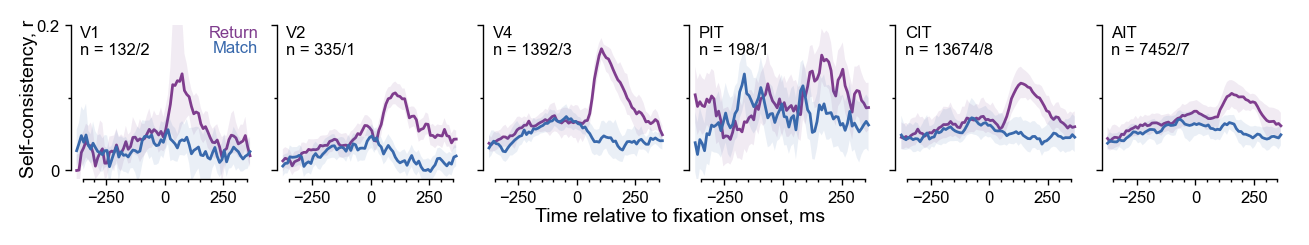

In [8]:
ncol = len(regions)
fig, axs = plt.subplots(1, ncol, figsize=(1.31*ncol, 1), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

ts = coords['time']
for region, ax in zip(regions, axs):
    m, bs = summary['one-level_center_boots'][region]
    for icond, cond in enumerate(conds):
        color = cond_palette[cond]
        ax.plot(ts, m[icond], color=color, zorder=2+icond/10)
        spread = get_bootstrap_spread(m[icond], bs[:,icond], spread_type)
        ax.fill_between(ts, *spread, ec='none', fc=color, alpha=0.1, zorder=1.95+icond/10)

xlim = (-400, 400)
xtks = (-250, 0, 250)
xmtks = np.arange(-350, 351, 50)
for ax in axs:
    ax.set_xlim(xlim)
    ax.set_xticks(xtks)
    ax.set_xticks(xmtks, minor=True)
    ax.spines['bottom'].set_bounds(xmtks.min(), xmtks.max())

ybound = (0,.2)
ylim = (-.0125, ybound[1])
ymtks = np.arange(*ybound,.1)
for ax in axs:
    ax.set_ylim(ylim)
    ax.set_yticks(ybound, list(map(str, ybound)))
    ax.set_yticks(ymtks, minor=True)
    ax.spines['left'].set_bounds(ybound)

ax = axs[0]
ax.set_ylabel('Self-consistency, r')
tform = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
ax.yaxis.set_label_coords(-.175, np.mean(ybound), transform=tform)

ax = fig.add_subplot(111)
axis_off_save_labels(ax)
ax.set_xlabel('Time relative to fixation onset, ms', labelpad=10)

annotate_per_region_axes(
    axs,
    regions,
    ns_per_region=summary['two-level_nunit'],
    conds=conds,
    palette=cond_palette,
    h=1)

print('center/spread estimate:', spread_type)

if 'match_control' in analysis_name:
    plt.savefig('plots/fig5i.png')

# Per-unit stat tests

In [9]:
reject = np.zeros(pvals.shape, dtype=bool)
apvals = np.full_like(pvals, np.nan)

for region, region_unit_df in unit_df.groupby('Region'):
    idc = region_unit_df['Index'].values
    for it in range(len(pvals)):
        idc_ = idc[np.isfinite(pvals[it,idc])]
        reject[it,idc_], apvals[it,idc_] = (v[None] for v in fdr_correction({None: pvals[it,idc_]}))

rej_summary = summarize_results_per_region(
    unit_df=unit_df,
    result_vals=reject[None,...],
    spread_type=spread_type)

center/spread estimate: ci_of_mean


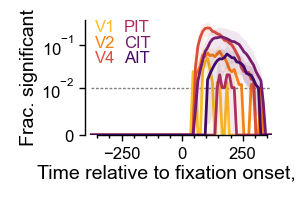

In [10]:
fig = plt.figure(figsize=(1.25, .75))
ax = plt.gca()

icond = 0
for ireg, region in enumerate(regions):
    color = region_palette[region]
    m, bs = rej_summary['one-level_center_boots'][region]
    ax.plot(ts, m[icond], color=color, zorder=2+ireg/10)
    spread = get_bootstrap_spread(m[icond], bs[:,icond], spread_type)
    ax.fill_between(ts, *spread, ec='none', fc=color, alpha=0.1, zorder=1.95+ireg/10)

ax.hlines(.01, ts[0], ts[-1], colors='gray', ls='--', lw=0.5, zorder=-1)
ax.set_yscale('symlog', linthresh=.01)

xlim = (-400, 400)
xtks = (-250, 0, 250)
xmtks = np.arange(-350, 351, 50)
ax.set_xlim(xlim)
ax.set_xticks(xtks)
ax.set_xticks(xmtks, minor=True)
ax.spines['bottom'].set_bounds(xmtks.min(), xmtks.max())
ax.set_xlabel('Time relative to fixation onset, ms')

ybound = (0, .4)
ax.set_ylim(ybound)
ax.spines['left'].set_bounds(ybound)
ax.set_ylabel('Frac. significant')

x = -.1
for i, region in enumerate(regions):
    if not (i % 3):
        h = 1
        x += .15
    color = region_palette[region]
    ax.text(
        x, h, region,
        ha='left', va='top', transform=ax.transAxes,
        color=color, fontsize=6)
    h -= .135

print('center/spread estimate:', spread_type)

if 'match_control' in analysis_name:
    plt.savefig('plots/fig5h2.png')
else:
    plt.savefig('plots/fig5h1.png')